# CAM Visualization
![title](./img/cam.png)


### Import modules

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import cv2
from cam import load_image, CAM

from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json 
from os import listdir
from os.path import isfile, join
from imutils import paths

import config
import random

### Test 이미지를 준비합니다.

In [17]:
totalTest = len(list(paths.list_images(config.TEST_PATH)))
input_size = (64,64)

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	config.TEST_PATH,
	class_mode="categorical",
	target_size=input_size,
	color_mode="rgb",
	shuffle=False,
	batch_size=100)

Found 5512 images belonging to 2 classes.


### 훈련시킨 모델을 불러 옵니다

In [18]:
# 모델의 구조 불러오기
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# 모델의 가중치 불러오기
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


### CAM 을 계산합니다

In [22]:
cam_image_number = 15
img_indexes = random.sample(range(0, totalTest - 1), cam_image_number)

# CAM 계산을 위해 Global average pooling layer 직전 layer의 이름을 사용합니다.
activation_layer = 'last_conv'

cam_generator = CAM(loaded_model, activation_layer)
cams = []
image_pathes = []

for index, img_index in enumerate(img_indexes):
    img_path = config.TEST_PATH + "/" + testGen.filenames[img_index]
    image_pathes.append(img_path)
    img = load_image(path=img_path, target_size=input_size)

    preds = loaded_model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    
    cam = cam_generator.generate(img, predicted_class) 
    cams.append(cam)

### 계산한 CAM Plot

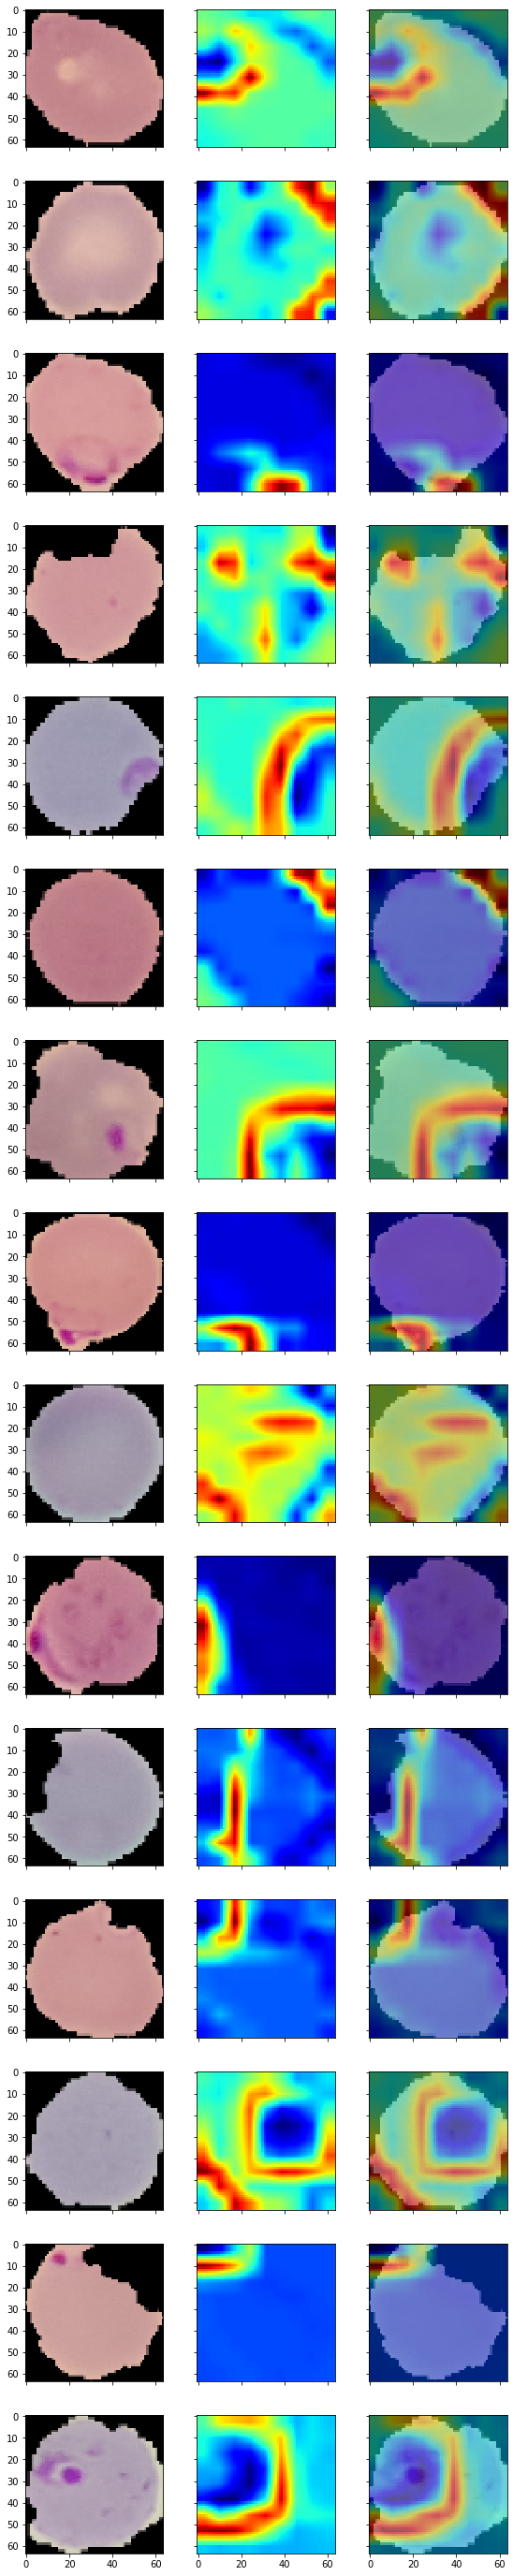

In [23]:
fig = plt.figure(figsize=(50.,50.))
from mpl_toolkits.axes_grid1 import ImageGrid
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(cam_image_number, 3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for index, cam in enumerate(cams):
    cam = cv2.resize(cam, input_size)
    
    img = cv2.imread(image_pathes[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, input_size)
    
    grid[index * 3].imshow(img)
    
    grid[index * 3 + 1].imshow(cam, cmap="jet")
    
    grid[index * 3 + 2].imshow(img)
    grid[index * 3 + 2].imshow(cam, cmap="jet", alpha=.5)

### Exercise
Pre-trained weight를 불러와서 기존의 CAM과 결과를 비교해 봅니다.